# DeepFake Video Detection

## Documentation

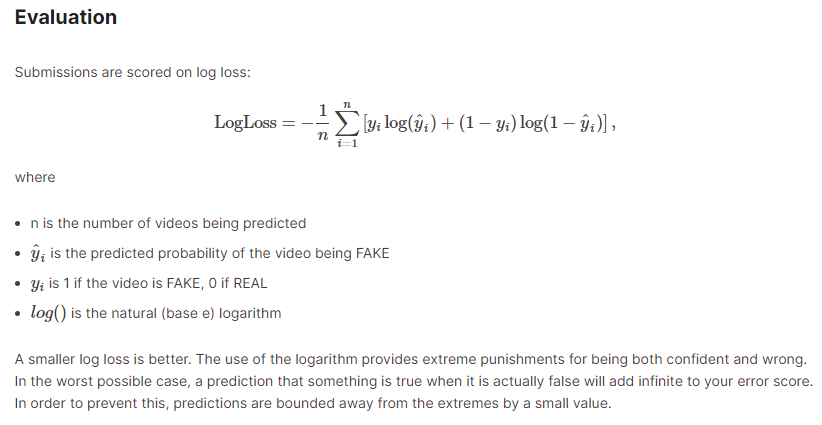

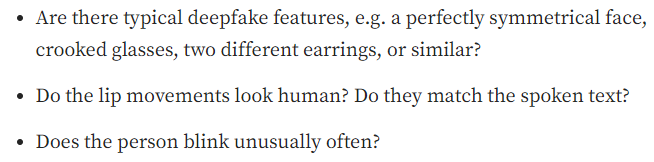

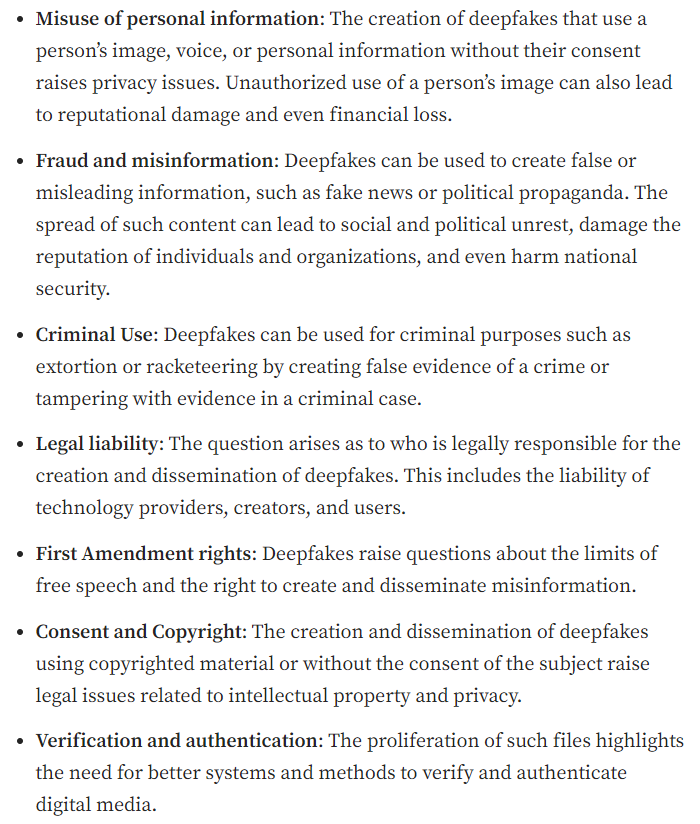

https://towardsdatascience.com/deepfake-detection-is-super-hard-38f98241ee49

## Install Packages

In [ ]:
'''
!pip install moviepy
!pip install ffpyplayer
'''

## Data Analyse

In [1]:
# Load packages

import os
from typing import Optional
import numpy as np
import pandas as pd

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torchinfo
import cv2 as cv

import matplotlib.pyplot as plt

In [2]:
# Parameters

DATA_FOLDER = 'E:\DeepFakeDetection\dfdc_train_all'

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The chosen device: {TORCH_DEVICE}')

The chosen device: cuda


In [16]:
part_folders = os.listdir(DATA_FOLDER)
meta_df = pd.DataFrame()

for ii in range(len(part_folders)):
    part_folder = part_folders[ii]
    part_subfolders = os.listdir(os.path.join(DATA_FOLDER, part_folder))
    part_subfolder = part_subfolders[0]
    part_subfolder_path = os.path.join(os.path.join(DATA_FOLDER, part_folder), part_subfolder)
    files = os.listdir(part_subfolder_path)
    json_file = [file for file in files if  file.endswith('json')][0]
    json_file_path = os.path.join(part_subfolder_path, json_file)
    part_df = pd.read_json(json_file_path).T
    part_df['part'] = ii
    part_df['path'] = part_subfolder_path
    #part_df['filename'] = part_df.index
    meta_df = pd.concat([meta_df, part_df])

display(meta_df)

,label,split,original,part,path
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
vpmyeepbep.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
fzvpbrzssi.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
...,...,...,...,...,...
pdooqxqfrm.mp4,FAKE,train,ikebomnsiq.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
djjdcnhlma.mp4,FAKE,train,kudvvlgiff.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
fgmbxfqoze.mp4,REAL,train,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...
cywebjaezn.mp4,REAL,train,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...


In [18]:
files_num = sum([len(files) for r, d, files in os.walk(DATA_FOLDER)])+1
print(f"Data samples: {files_num}")

Data samples: 119197


<Axes: title={'center': 'Histogram of Classes / Labels'}, xlabel='Class', ylabel='Count'>

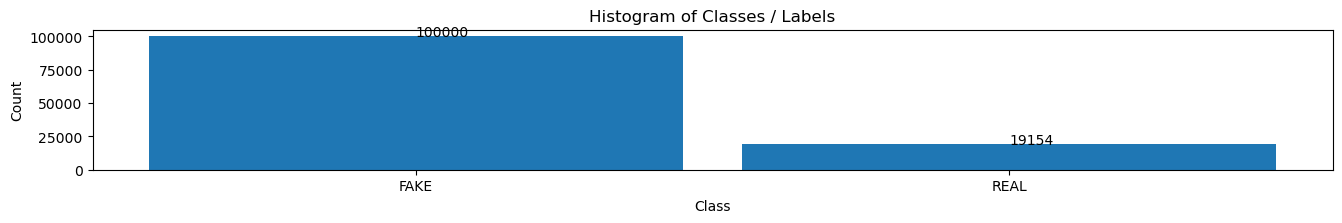

In [19]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def PlotLabelsHistogram(vY: np.ndarray, labels_list, hA: Optional[plt.Axes] = None ) -> plt.Axes:
    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    vLabels, vCounts = np.unique(vY, return_counts = True)
    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    addlabels(vLabels, vCounts)
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_xticks(vLabels, labels_list)
    hA.set_ylabel('Count')
    return hA

plt.figure(figsize=(16, 4))
ax = plt.subplot(2,1,1)
PlotLabelsHistogram(meta_df['label'],meta_df['label'].unique(),ax)

## Data Analyze

'E:\\DeepFakeDetection\\dfdc_train_all\\dfdc_train_part_00\\dfdc_train_part_0\\owxbbpjpch.mp4'

'E:\\DeepFakeDetection\\dfdc_train_all\\dfdc_train_part_00\\dfdc_train_part_0\\wynotylpnm.mp4'

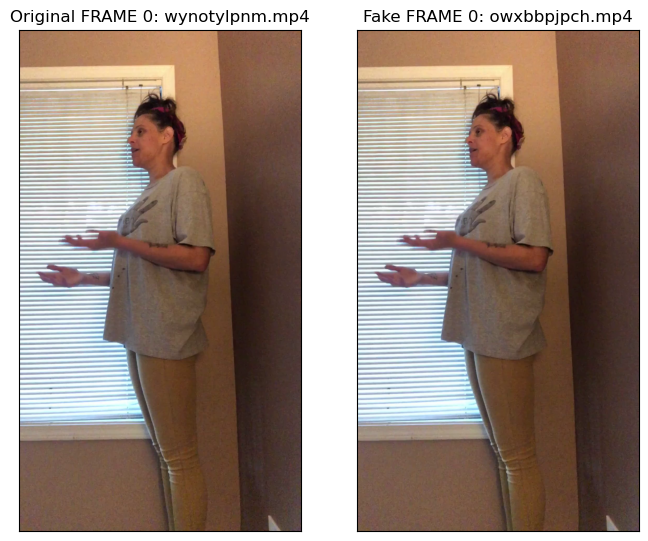

In [6]:
fake_mdata = meta_df[meta_df["label"]=="FAKE"].iloc[[0],:]
filedir = fake_mdata["path"][0]
fake_filename = fake_mdata.index[0]
orig_filename = fake_mdata["original"][0]
fake_filepath = filedir + "\\" + fake_filename
orig_filepath = filedir + "\\" + orig_filename

cap = cv.VideoCapture(orig_filepath)
success, image = cap.read()
orig_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release() 
cap = cv.VideoCapture(fake_filepath)
success, image = cap.read()
fake_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release() 

fig, ax = plt.subplots(1,2, figsize=(8, 7))
ax[0].imshow(orig_image)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].title.set_text(f"Original FRAME 0: {orig_filename}")
plt.grid(False)
ax[1].imshow(fake_image)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].title.set_text(f"Fake FRAME 0: {fake_filename}")
plt.grid(False)


In [ ]:
'''
from moviepy.editor import *

video = VideoFileClip(fake_filepath)
video.ipython_display(width=256)
'''

In [ ]:
'''
cap = cv.VideoCapture(fake_filepath)
 
while cap.isOpened():
    ret, frame = cap.read()

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    #gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    cv.imshow('frame',frame) # , gray
    if cv.waitKey(1) == ord('q'):
        break
 
cap.release()
cv.destroyAllWindows()
'''

In [14]:
def LoadVideo(filepath):
    frames = []
    cap = cv.VideoCapture(filepath)

    while cap.isOpened():
        ret, frame = cap.read()

        # if frame is read correctly ret is True
        if not ret:
            break
        frames.append(frame)

    cap.release()
    cv.destroyAllWindows()
    frames = np.array(frames)
    frames = torch.tensor(frames)
    return frames

In [15]:
frames = LoadVideo(fake_filepath)
frames.shape

torch.Size([300, 1920, 1080, 3])

## Pytorch

In [ ]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self,data_path):
        super(MyIterableDataset).__init__()
        self.data_path = data_path
    def __iter__(self):
        # frames = LoadVideo(fake_filepath)
        return iter(range(iter_start, iter_end))
    
# should give same set of data as range(3, 7), i.e., [3, 4, 5, 6].
ds = MyIterableDataset(start=3, end=7)

torch.utils.data.DataLoader(ds, num_workers=0)

In [ ]:
dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)

In [6]:
oModel = nn.Sequential(
    nn.Identity(),                            #<! For the summary (Shows the input)
    nn.Linear(100, 50),            nn.ReLU(), #<! z1 = σ(W1 * x + b1)
    nn.Linear(50,  25),            nn.ReLU(), #<! z2 = σ(W2 * z1 + b2)
    nn.Linear(25,  10, bias = False)          #<! y  = W3 * z2 (No Bias)
    )

numSamples  = 16
dataDim     = 100
display(torchinfo.summary(oModel, input_size = (numSamples, dataDim))) #<! By default tries on CUDA
print(f'The model device: {next(oModel.parameters()).device}')

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 10]                  --
├─Identity: 1-1                          [16, 100]                 --
├─Linear: 1-2                            [16, 50]                  5,050
├─ReLU: 1-3                              [16, 50]                  --
├─Linear: 1-4                            [16, 25]                  1,275
├─ReLU: 1-5                              [16, 25]                  --
├─Linear: 1-6                            [16, 10]                  250
Total params: 6,575
Trainable params: 6,575
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04

The model device: cuda:0
